**To download and untar the dataset in colab:**

```bash
! mkdir -P /content/drive/MyDrive/datasets/deepsig
! wget -P /content/drive/MyDrive/datasets/deepsig https://f002.backblazeb2.com/file/deepsig-datasets/2016.10/RML2016.10b.tar.bz2?Authorization=3_20221227213905_2c795ffc54e9046c69c5217c_469e51be5cab6f465d8a532240da083f077ea3dc_002_20221227223905_0027_dnld
! mv /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2?Authorization=3_20221227213905_2c795ffc54e9046c69c5217c_469e51be5cab6f465d8a532240da083f077ea3dc_002_20221227223905_0027_dnld /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2
! tar -xvf /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2 -C /content/drive/MyDrive/datasets/deepsig/RML2016.10b
! rm /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2
```

> Note : 
> The link will not work, you will have to request a link from the website.

# Imports and Constants

In [1]:
import pickle

import numpy as np
import scipy as sci
from scipy.integrate import cumulative_trapezoid

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ROOT = '/kaggle/input/rml2016'
DAT = ROOT + '/RML2016.10b.dat'

# Loading and exploring the data

In [2]:
# from https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb
# modified for python 3
Xd = pickle.load(open(DAT, 'rb'), encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
y = np.array(lbl)

X.shape, y.shape

((1200000, 2, 128), (1200000, 2))

In [3]:
# The labels
print(f'{np.unique(y[:,0],return_counts=True)}\n\n\
{np.unique(y[:,1],return_counts=True)}')

(array(['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16',
       'QAM64', 'QPSK', 'WBFM'], dtype='<U21'), array([120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000,
       120000, 120000]))

(array(['-10', '-12', '-14', '-16', '-18', '-2', '-20', '-4', '-6', '-8',
       '0', '10', '12', '14', '16', '18', '2', '4', '6', '8'],
      dtype='<U21'), array([60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000,
       60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000,
       60000, 60000]))


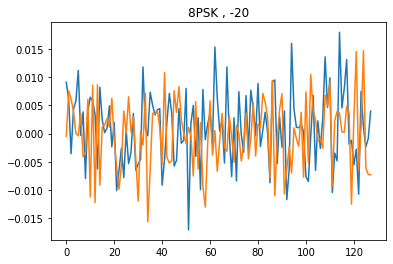

In [4]:
plt.plot(X[0,0])
plt.plot(X[0,1])
plt.title(f'{y[0,0]} , {y[0,1]}')
plt.show()

## Signal derivative

In [5]:
d_np = np.gradient(X[0,0])

lines=[d_np,X[0,0]]

t = np.linspace(0,127,128)

fig = go.Figure()
fig.add_trace(go.Line(x=t,y=lines[0],name=f'derivative'))
fig.add_trace(go.Line(x=t,y=lines[1],name=f'original signal'))

fig.show()

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## Signal Integral

In [6]:
i_ct = cumulative_trapezoid(X[0,0])

lines=[i_ct,X[0,0]]

t = np.linspace(0,127,128)

fig = go.Figure()
fig.add_trace(go.Line(x=t,y=lines[0],name=f'cumulative trapezoid'))

fig.add_trace(go.Line(x=t,y=lines[1],name=f'original signal'))

fig.show()

# Creating Feature Spaces

Possible feature spaces:

1. raw signal
2. derivative
3. integration
4. raw and derivative
5. raw and integration
6. derivative and integration
7. raw and derivative and integration


In [7]:
X_raw = X
X_diff = np.gradient(X,axis=-1)
X_int = np.zeros_like(X)
X_int[:,:,:-1] = np.array(cumulative_trapezoid(X))

X_raw_diff = np.concatenate((X_raw,X_diff),axis=1)
X_raw_int = np.concatenate((X_raw,X_int),axis=1)
X_diff_int = np.concatenate((X_diff,X_int),axis=1)

X_all = np.concatenate((X_raw,X_diff,X_int),axis=1)

print(f'\
Shapes\n\
X_raw: {X_raw.shape}\n\
X_diff: {X_diff.shape}\n\
X_int: {X_int.shape}\n\n\
X_raw_diff: {X_raw_diff.shape}\n\
X_raw_int: {X_raw_int.shape}\n\
X_diff_int: {X_diff_int.shape}\n\n\
X_all: {X_all.shape}')

Shapes
X_raw: (1200000, 2, 128)
X_diff: (1200000, 2, 128)
X_int: (1200000, 2, 128)

X_raw_diff: (1200000, 4, 128)
X_raw_int: (1200000, 4, 128)
X_diff_int: (1200000, 4, 128)

X_all: (1200000, 6, 128)


In [8]:
del X_diff
del X_int

del X_raw_diff
del X_raw_int
del X_diff_int

del X_all

In [9]:
import gc
for _ in range(5):
    gc.collect()

# Data Splitting

In [10]:
def split(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state =1, stratify = y[:,0])
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.05, random_state =1, stratify = y_train[:,0])
    return x_train, x_val, x_test, y_train, y_val, y_test

# Models

## Hyperparameters

In [11]:
EPOCHS = 100
PATIENCE = 5
LEARNING_RATE = 0.001

## CNN model
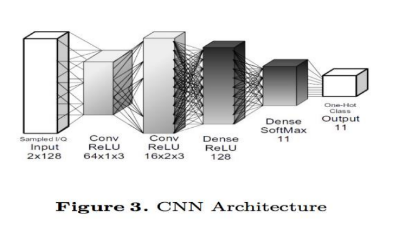

In [12]:
cnn_input_shape = X_raw.shape[1:] + (1,)

cnn_model = keras.Sequential([
    layers.Conv2D(64,
                kernel_size=3,
                activation='relu',
                  padding='same',
                input_shape=cnn_input_shape),
    layers.Conv2D(16,
                 kernel_size=3,
                  strides=2,
                  padding='same',
                 activation='relu'),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(11,activation='softmax'),
],name='cnn_2_ch')

optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
loss = keras.losses.CategoricalCrossentropy()
cnn_model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

cnn_model.summary()
# TODO: questions: 
# is it conv1D
# 1. Padding?
# 2. what is x1  and x2 in 2nd and 3rd layer? kernel size or number of Conv?

Model: "cnn_2_ch"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2, 128, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 64, 16)         9232      
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1419      
Total params: 142,491
Trainable params: 142,491
Non-trainable params: 0
_________________________________________________________________


2022-12-30 21:06:46.869448: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [13]:
values = np.arange(0.000001,0.0003,0.00005)[::-1]
boundaries = np.arange(5, 100,5)[:values.shape[0]-1]


scheduler = keras.optimizers.schedules.PiecewiseConstantDecay(
    list(boundaries), list(values))

lrscheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience = PATIENCE, mode='min')


def configure_checkpoints(path):

    return keras.callbacks.ModelCheckpoint(
        filepath=path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
    


In [14]:
def train_and_plot(model,checkpoint_path,x_train,y_train,x_val,y_val,epochs=EPOCHS):
    checkpoint = configure_checkpoints(checkpoint_path)
    history=model.fit(
        x=np.array(x_train),
        y=y_train,
        epochs=epochs,
        validation_data=(np.array(x_val),y_val),
        callbacks=[checkpoint,early_stopping]
    )

    num=len(history.history['loss'])

    plt.plot(range(num),history.history['loss'],label = 'training loss')
    plt.plot(range(num),history.history['val_loss'],label = 'validation loss')

    plt.legend()

    plt.xlabel("Epochs ")
    plt.ylabel('Loss')

    plt.figure()

    plt.plot(range(num),history.history['accuracy'],label = 'training accuracy')
    plt.plot(range(num),history.history['val_accuracy'],label = 'validation accuracy')

    plt.legend()
    plt.xlabel("Epochs ")
    return history

In [15]:
x_train, x_val, x_test, y_train, y_val, y_test = split(X_raw,y)

In [16]:
y_test[:,0].shape,np.concatenate((y_test[:,0],np.array(["None"]))).shape

((360000,), (360001,))

In [17]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(np.concatenate((y_test[:,0],np.array(["None"]))).reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_test_encoded.shape

(360000, 11)

In [18]:
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))

In [19]:
np.unique(y_val_encoded,axis=0,return_counts=True)

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([4200, 4200, 4200, 4200, 4200, 4200, 4200, 4200, 4200, 4200]))

2022-12-30 21:06:55.054042: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
24938/24938 [==============================] - 213s 8ms/step - loss: 1.3535 - accuracy: 0.4498 - val_loss: 1.1612 - val_accuracy: 0.5190
Epoch 2/100
24938/24938 [==============================] - 216s 9ms/step - loss: 1.1469 - accuracy: 0.5221 - val_loss: 1.1270 - val_accuracy: 0.5342
Epoch 3/100
24938/24938 [==============================] - 219s 9ms/step - loss: 1.1233 - accuracy: 0.5313 - val_loss: 1.1145 - val_accuracy: 0.5339
Epoch 4/100
24938/24938 [==============================] - 216s 9ms/step - loss: 1.1028 - accuracy: 0.5384 - val_loss: 1.0962 - val_accuracy: 0.5420
Epoch 5/100
24938/24938 [==============================] - 212s 8ms/step - loss: 1.0887 - accuracy: 0.5436 - val_loss: 1.0969 - val_accuracy: 0.5370
Epoch 6/100
24938/24938 [==============================] - 214s 9ms/step - loss: 1.0786 - accuracy: 0.5468 - val_loss: 1.0891 - val_accuracy: 0.5401
Epoch 7/100
24938/24938 [==============================] - 212s 9ms/step - loss: 1.0693 - accuracy: 0.5507

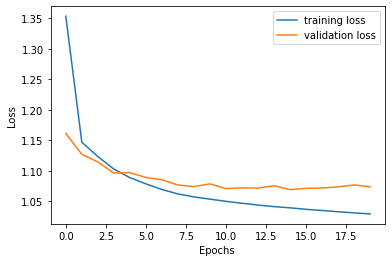

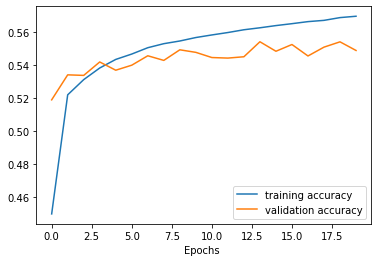

In [20]:
cnn_history = train_and_plot(
    cnn_model,
    "/kaggle/working/checkpoints/cnn",
    x_train.reshape(x_train.shape+(1,)),
    y_train_encoded,
    x_val.reshape(x_val.shape+(1,)),
    y_val_encoded,
    epochs=EPOCHS
)